# Mac Address Feature Cleaning

The notebook aims at understanding the mac addresses using a clustering algorithm (k-means) to determine whether the mac addresses are stationary or moving (shoppers).

In [19]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils

## Import the data and create mac address data frame

In [4]:
mac_address_df = utils.import_mac_addresses()

In [5]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

154152 mac addresses with 20 features


## Cluster Analysis

In [84]:
mac_address_clean_df['turning_angle_density'] = \
    mac_address_clean_df['total_turning_angle'] / mac_address_clean_df['total_path_length']

In [104]:
FEATURE_LIST = [
    'frequency',
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'total_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'total_path_length',
    'av_straightness',
]

In [47]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [48]:
mac_address_clean_df.describe()

,frequency,radius_of_gyration,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,total_turning_angle,av_turning_angle_velocity,av_path_length,total_path_length,av_straightness,shopper,mall_worker,stationary_device,other
count,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.00,24698.00,24698.00,24698.00
mean,99.168192,57.049145,2.834673,12774.062394,0.024293,1.021272,1.673795,122.253805,0.015792,24.508113,1557.665749,2.249470,0.25,0.25,0.25,0.25
std,236.829598,28.286915,1.744639,18461.612314,0.153962,1.321809,0.374253,326.705106,0.345792,14.572529,2727.892611,1.025246,0.00,0.00,0.00,0.00
min,11.000000,2.757971,0.000000,87.000000,0.000000,0.010512,0.003405,0.006810,-3.127440,0.738739,31.266267,1.000000,0.25,0.25,0.25,0.25
25%,18.000000,34.761026,1.527525,1617.000000,0.000000,0.442780,1.435782,19.810838,-0.064269,14.760119,499.365915,1.620108,0.25,0.25,0.25,0.25
50%,39.000000,60.131718,2.516880,5641.500000,0.000000,0.640534,1.676079,41.074166,0.005753,20.718671,995.459489,2.024349,0.25,0.25,0.25,0.25
75%,92.000000,78.530414,3.728909,13309.750000,0.000000,1.015459,1.908746,102.377398,0.086343,30.386136,1730.159690,2.572965,0.25,0.25,0.25,0.25
max,6606.000000,155.334048,20.506097,86335.000000,1.000000,23.011323,3.141593,6745.491906,3.119332,144.446255,140958.829109,32.689138,0.25,0.25,0.25,0.25


We need to scale each feature into a Gaussian distribution.

In [86]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [87]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### Kmeans

In [88]:
n_clusters = 2

model = KMeans(n_clusters=n_clusters)
model.fit(samples)
labels = model.predict(samples)

In [89]:
mac_address_clean_df['k_means_label'] = labels

In [90]:
mac_address_clean_df.k_means_label.value_counts()

0    23731
1      967
Name: k_means_label, dtype: int64

### Gaussian Mixture

In [91]:
samples = mac_address_clean_df.as_matrix(
    columns=FEATURE_LIST
)

In [92]:
model = BayesianGaussianMixture(n_components=3)
model.fit(samples)
labels = model.predict(samples)

In [93]:
model.predict_proba(samples)[:, 0]

array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
         5.03345005e-006,   3.20732441e-010,   1.60019979e-223])

In [94]:
mac_address_clean_df['gaussian_mixture_label'] = labels

In [95]:
mac_address_clean_df.gaussian_mixture_label.value_counts()

0    11053
2    10842
1     2803
Name: gaussian_mixture_label, dtype: int64

### Baysian

In [71]:
from msci.cleaning.bayesian_inference import sequential

In [110]:
%%prun

prob_estimates = sequential(0.2, mac_address_df, FEATURE_LIST)

frequency (0.849486674097077, 9.761748526974903e-09)
frequency (0.9218500468437009, 7.841004004272413e-09)
length_of_stay (0.9975249212531696, 1.1808917077478683e-08)
length_of_stay (0.8808903821172067, 1.076492169117548e-08)
radius_of_gyration (0.9301066633808558, 6.702239141162929e-10)
radius_of_gyration (0.9967946402554867, 1.1518872537022233e-08)
count_density_variance (0.0, 0.0)
count_density_variance (0.0, 0.0)
av_speed (0.0, 0.0)
av_speed (0.0, 0.0)
av_turning_angle (0.0, 0.0)
av_turning_angle (0.0, 0.0)
total_turning_angle (0.7918558865827524, 6.714515305553297e-12)
total_turning_angle (0.8726156948426869, 1.3859207488113858e-08)
av_turning_angle_velocity (0.0, 0.0)
av_turning_angle_velocity (0.0, 0.0)
av_path_length (0.9232874679569462, 1.4637317927808285e-08)
av_path_length (0.9982096729925798, 1.4899404968155085e-08)
total_path_length (0.8192429686989352, 1.0978628708156501e-10)
total_path_length (0.9585197096473755, 1.3262452696898487e-08)
av_straightness (0.0, 0.0)
av_stra

In [73]:
mac_address_df['shopper'] = prob_estimates[-1][1]
mac_address_df['stationary_device'] = prob_estimates[-1][0]


In [76]:
mac_address_clean_df.shopper = mac_address_df.shopper

## Correlation plots

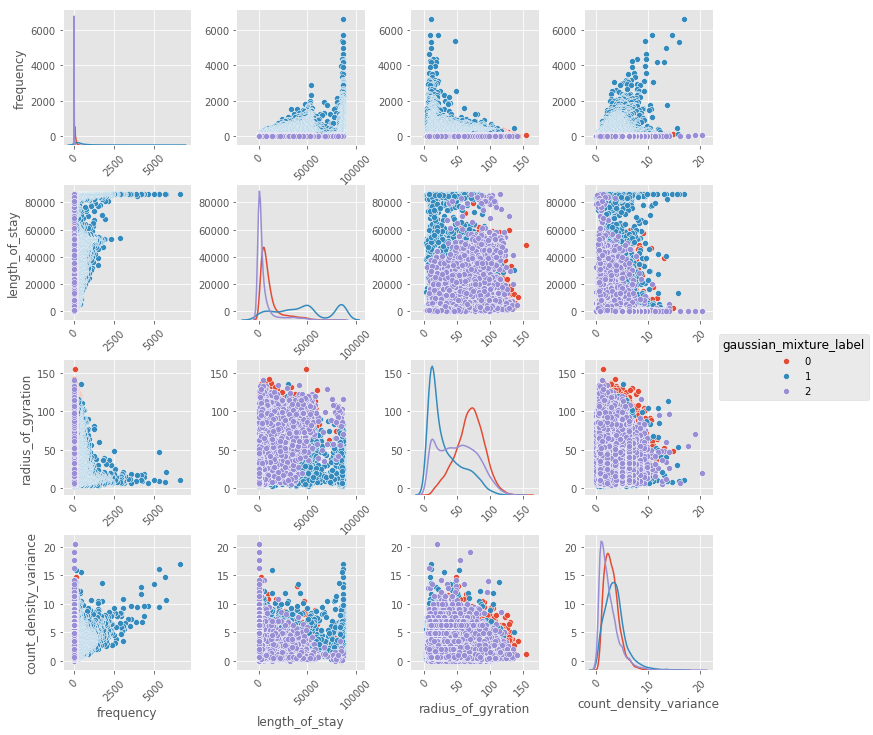

In [96]:
LABEL = 'gaussian_mixture_label'

g = sns.pairplot(
    mac_address_clean_df, 
    vars=FEATURE_LIST[:4],
    hue=LABEL, diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Venn Diagrams

In [100]:
k_means_stationary_index = mac_address_clean_df[mac_address_clean_df.k_means_label == 1].index.tolist()
bayesian_stationary_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 1].index.tolist()
out_of_hours_stationary_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 1].index.tolist()
bayes_stationary_index = mac_address_clean_df[mac_address_clean_df.shopper < 0.1].index.tolist()

In [101]:
k_means_non_stationary_index = mac_address_clean_df[mac_address_clean_df.k_means_label == 0].index.tolist()
bayesian_non_stationary_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 0].index.tolist()
out_of_hours_non_stationary_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 0].index.tolist()
bayes_non_stationary_index = mac_address_clean_df[mac_address_clean_df.shopper > 0.9].index.tolist()

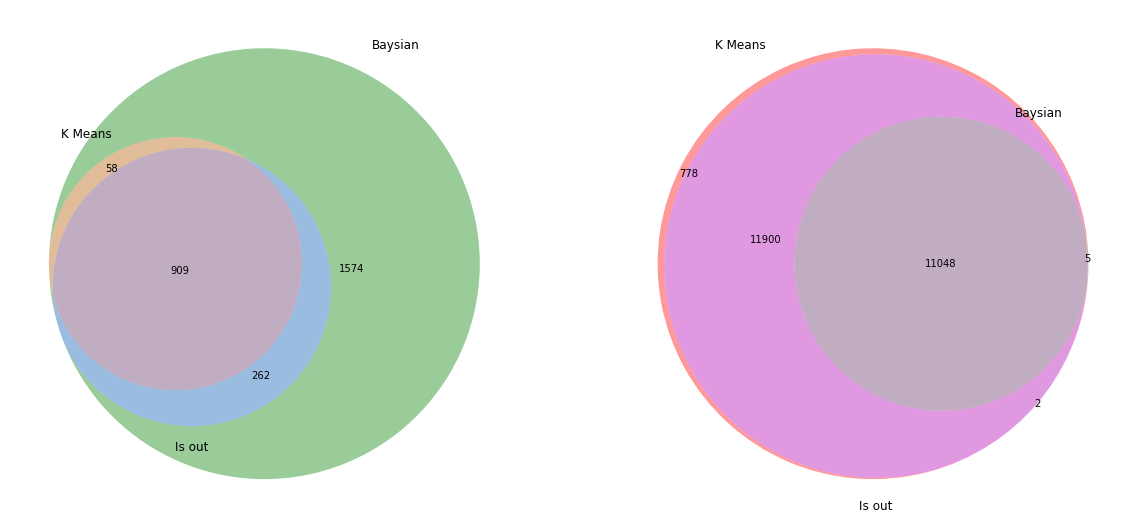

In [102]:
from matplotlib_venn import venn3

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))

set1 = set(k_means_stationary_index)
set2 = set(bayesian_stationary_index)
set3 = set(bayes_stationary_index)

venn3([set1, set2, set3], ('K Means', 'Baysian', 'Is out'), ax=ax1)


set1 = set(k_means_non_stationary_index)
set2 = set(bayesian_non_stationary_index)
set3 = set(bayes_non_stationary_index)

venn3([set1, set2, set3], ('K Means', 'Baysian', 'Is out'), ax=ax2)